# Synthetic Datasets Analyzer on Measuring and Mitigating in Treatment Discrimination

#### Importing packages

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles
import numpy as np
from utils.notebook_helpers import *
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_columns', 10)

In [4]:
bundles.aaai2024()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.3, 2.039512162874653),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 9,
 'axes.labelsize': 9,
 'legend.fontsize': 7,
 'xtick.labelsize': 7,
 'ytick.labelsize': 7,
 'axes.titlesize': 9}

In [5]:
plt.rcParams.update(bundles.aaai2024())
# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 150})

In [6]:
root_path = '_models_trained/causal_nf'


---------

<h2 style="color:#007acc;"> Imbalanced Synthetic Loan</h2>

 
---------

Generated with the following: $\beta=0.03, \gamma=0.5, \delta=2, \eta=5$


In [7]:
# choose: train, val, test, all
data_df = load_csv_file(root_path, 'imbalancedsynthetic', 'all')
params = load_yaml_config(root_path, 'imbalancedsynthetic')
oracle_meta_df = pd.read_csv('Data/treatment_imbalancedsynthetic/meta.csv', header=0) # contains the counterfactuals
oracle_data_df = pd.read_csv('Data/treatment_imbalancedsynthetic/data.csv', header=0) # original data

col_names = ['Gender_CF', 'Age_CF', 'Education_CF', 'Income_CF', 'Savings_CF', 'Loan_amt_CF', 'Duration_CF', 'Y_CF', 'Y_TTD',
       'Gender_PSDT', 'Age_PSDT', 'Education_PSDT', 'Income_PSDT', 'Savings_PSDT', 'Loan_amt_PSDT', 'Duration_PSDT',
       'Y_PDSL', 'Y_PSDT']
oracle_meta_df.columns = col_names

In [8]:
oracle = oracle_data_df.copy()
oracle_counterfactuals = oracle_meta_df.copy()

oracle.columns = [col + '_F' for col in oracle.columns]
merged_oracle = pd.concat([oracle, oracle_counterfactuals], axis=1)

In [9]:
treatment_col_idxs = range(params['dataset__num_sensitive'] + params['dataset__num_covariate'], 
                           params['dataset__num_sensitive'] + params['dataset__num_covariate'] + params['dataset__num_treatment'])

total_features = params['dataset__num_sensitive'] + params['dataset__num_covariate'] + params['dataset__num_treatment'] + 1

treatment_features = [c.split('_F')[0] for c in data_df.columns[treatment_col_idxs]]

print('Treatment features:', treatment_features)

gender_col_name = data_df.columns[0].split('_F')[0]
class_col_name = data_df.columns[total_features - 1].split('_F')[0]

Treatment features: ['Loan_amt', 'Duration']


### Downstream effect of Total treatment discrimination (TTD_E): $Y(S^F,X^F,do(Z=Z^{CF}))$

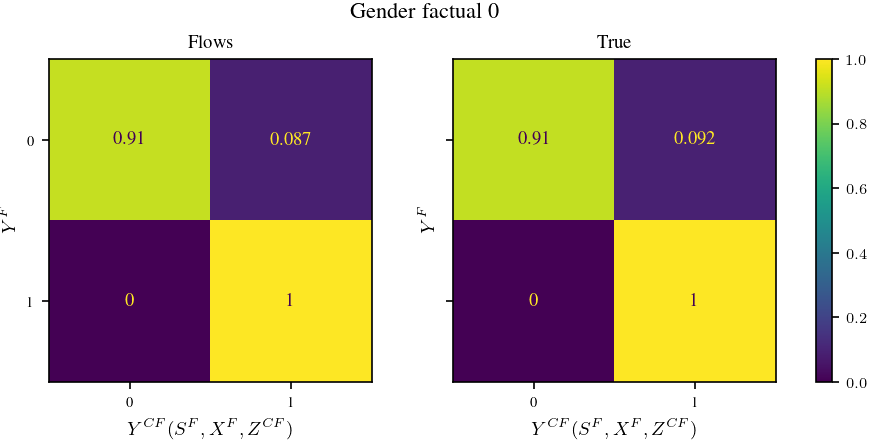

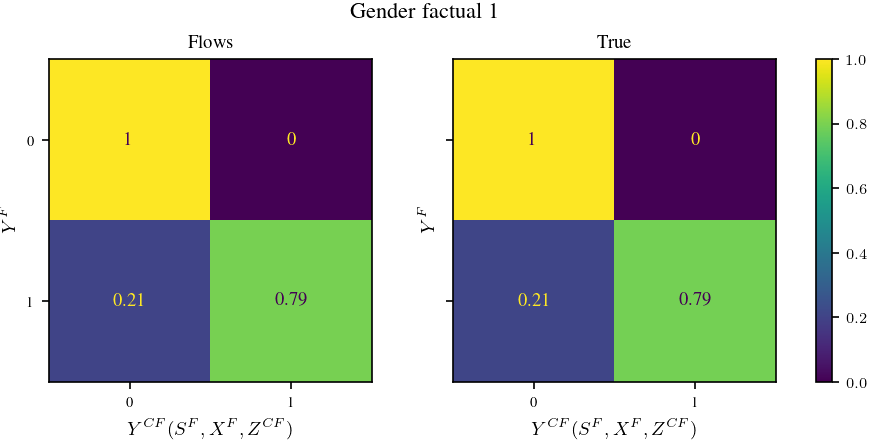

In [10]:
for gender_val in [0, 1]:
    f, axes = plt.subplots(1, 2, figsize=(6, 3), sharey='row')
    sens_0 = data_df[data_df[f'{gender_col_name}_F'] == gender_val]
    orac_m_0 = oracle_meta_df[oracle_data_df[f'{gender_col_name}'] == gender_val]
    orac_d_0 = oracle_data_df[oracle_data_df[f'{gender_col_name}'] == gender_val]
    cm_1 = confusion_matrix(sens_0[f'{class_col_name}_F'], sens_0[f'{class_col_name}_TTD'], labels=[0, 1], normalize='true')
    cm_2 = confusion_matrix(orac_d_0[f'{class_col_name}'], orac_m_0[f'{class_col_name}_TTD'], labels=[0, 1], normalize='true')
    disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=[0, 1])
    disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=[0, 1])
    disp_1.plot(ax=axes[0])
    disp_1.im_.colorbar.remove()
    disp_2.plot(ax=axes[1])
    disp_2.im_.colorbar.remove()
    axes[0].set_title('Flows')
    axes[1].set_title('True')
    for i in range(2):
        axes[i].set_ylabel('$Y^F$')
        axes[i].set_xlabel('$Y^{CF}(S^{F},X^{F},Z^{CF})$')
    f.suptitle(f'Gender factual {gender_val}')
    f.colorbar(disp_2.im_, ax=axes)

### Downstream effect of path-specific treatment (DTD_E): $Y(S^F,X^F,Z(do(S=S^{CF}), do(X=X^F)))$

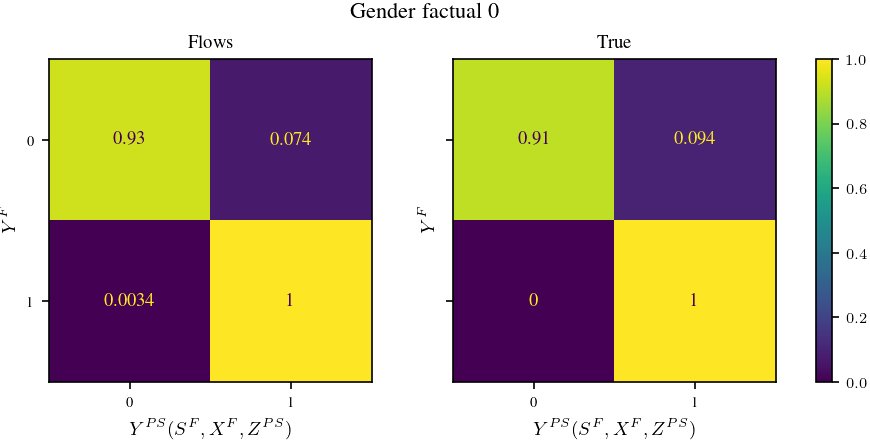

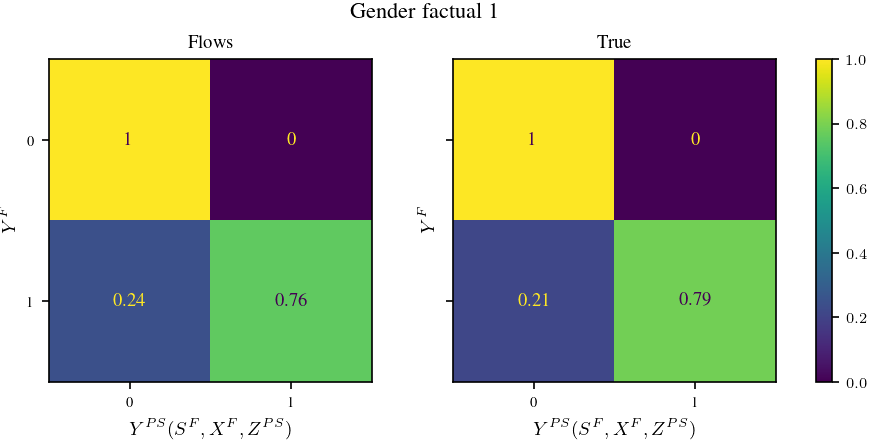

In [11]:
for gender_val in [0, 1]:
    f, axes = plt.subplots(1, 2, figsize=(6, 3), sharey='row')
    sens_0 = data_df[data_df[f'{gender_col_name}_F'] == gender_val]
    orac_m_0 = oracle_meta_df[oracle_data_df[f'{gender_col_name}'] == gender_val]
    orac_d_0 = oracle_data_df[oracle_data_df[f'{gender_col_name}'] == gender_val]
    cm_1 = confusion_matrix(sens_0[f'{class_col_name}_F'], sens_0[f'{class_col_name}_PSDT'], labels=[0, 1], normalize='true')
    cm_2 = confusion_matrix(orac_d_0[f'{class_col_name}'], orac_m_0[f'{class_col_name}_PSDT'], labels=[0, 1], normalize='true')
    disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=[0, 1])
    disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=[0, 1])
    disp_1.plot(ax=axes[0])
    disp_1.im_.colorbar.remove()
    disp_2.plot(ax=axes[1])
    disp_2.im_.colorbar.remove()
    axes[0].set_title('Flows')
    axes[1].set_title('True')
    for i in range(2):
        axes[i].set_ylabel('$Y^F$')
        axes[i].set_xlabel('$Y^{PS}(S^{F},X^{F},Z^{PS})$')
    f.suptitle(f'Gender factual {gender_val}')
    f.colorbar(disp_2.im_, ax=axes)

### Direct and Total Discrimination

For each group $S^F=0$ and $S^F=1$, Total Treatment Discrimination is:

$TTD_{S^F \in [0,1]} = Z^{CF}(do(S=S^{CF})) - Z^F$

Similarly, the Direct Treatment Discrimination is measured with respect to the path-specific of the treatment as:

$DTD_{S^F \in [0, 1]} = Z^{SPCF}(do(S=S^{CF}), do(X=X^F)) - Z^F$

#### a. Plot and get results dict for TD and DTD

In [12]:
plot_params = {'rows': 1, 'cols': 2, 'figsize': (7, 1.7), 'plot_idx_legend': 1}
result_dict = dtd_itd_analysis(data_df, params, plot=False, plot_params=plot_params)

In [13]:
for k in result_dict.keys():
    res = result_dict[k]
    cols = [f'{k}'] + [c for c in treatment_features]
    rows = []
    for meas in ['TD', 'DTD']:
        val_row = {cols[0]: meas}
        i = 1
        for c in treatment_features:
            val_row[cols[i]] = f'{res[meas][c][0]}+/-{res[meas][c][1]}'
            i += 1
        rows.append(val_row)
    df = pd.DataFrame(rows)
    print(df)
    print('---------')

  Overall                                 Loan_amt  \
0      TD            0.8889445+/-2.148817881024637   
1     DTD  1.2666578499999996+/-2.0780806797484894   

                                  Duration  
0  2.7693283500000003+/-4.8555293454795745  
1   3.9253324999999983+/-4.727776908858197  
---------
  Gender 0                                 Loan_amt  \
0       TD   -1.921259000000001+/-1.125953579849768   
1      DTD  -1.5505849999999999+/-0.927102886701032   

                         Duration  
0  -4.612197+/-1.7666525278782366  
1  -3.751107+/-1.5665303712184155  
---------
  Gender 1                                 Loan_amt  \
0       TD   2.000594999999999+/-1.1319959170930256   
1      DTD  2.2078646999999996+/-1.1360534042774755   

                                  Duration  
0            4.689813+/-1.8143698639653973  
1  5.4480146000000005+/-1.5159120541794249  
---------


#### Analysis for Oracle Discrimination in Treatment

In [14]:
# merged_oracle
plot_params = {'rows': 1, 'cols': 2, 'figsize': (7, 1.7), 'plot_idx_legend': 1}
result_dict_oracle = dtd_itd_analysis(merged_oracle, params, plot=False, plot_params=plot_params)

In [15]:
for k in result_dict_oracle.keys():
    res = result_dict_oracle[k]
    cols = [f'{k}'] + [c for c in treatment_features]
    rows = []
    for meas in ['TD', 'DTD']:
        val_row = {cols[0]: meas}
        i = 1
        for c in treatment_features:
            val_row[cols[i]] = f'{res[meas][c][0]}+/-{res[meas][c][1]}'
            i += 1
        rows.append(val_row)
    df = pd.DataFrame(rows)
    print(df)
    print('---------')

  Overall                                 Loan_amt  \
0      TD  1.8200000000000003+/-1.9215678618729464   
1     DTD  1.9500000000000002+/-1.9686765356234783   

                                 Duration  
0                4.77+/-4.868123081396611  
1  4.830000000000001+/-4.9160440720066365  
---------
  Gender 0                                   Loan_amt  \
0       TD  -1.9499999999999993+/-0.18360039006396484   
1      DTD                  -2.0+/-0.1656886858010858   

                                  Duration  
0  -4.949999999999999+/-0.2384311800368841  
1                -5.0+/-0.2194030275783843  
---------
  Gender 1                                 Loan_amt  \
0       TD  1.9499999999999997+/-0.1814324446910313   
1      DTD                 2.0+/-0.1637055869233007   

                                  Duration  
0  4.949999999999999+/-0.24426111148715288  
1                 5.0+/-0.2253342281801529  
---------


### Mitigation Approaches

In [16]:
# LGD 
df_0 = data_df[data_df[f'{gender_col_name}_F'] == 0]
df_1 = data_df[data_df[f'{gender_col_name}_F'] == 1]

Females in this dataset seems to be at the disadvantage since the TTD has a negative downstream effect on them than the males.

In [17]:
#lgd
factual_female_lgd = np.mean((1 - df_0[f'{class_col_name}_F']) * df_0['Loan_amt_F'])
factual_male_lgd = np.mean((1 - df_1[f'{class_col_name}_F']) * df_1['Loan_amt_F'])
counterfactual_male_lgd = np.mean((1 - df_1[f'{class_col_name}_TTD']) * df_1['Loan_amt_CF'])
counterfactual_female_lgd = np.mean((1 - df_0[f'{class_col_name}_TTD']) * df_0['Loan_amt_CF'])
print(f"<LGD> Factual female: {factual_female_lgd}, Treated Females: {counterfactual_female_lgd}, Factual male: {factual_male_lgd}, Treated male: {counterfactual_male_lgd}",
)

# ESI
factual_female_esi = np.mean((df_0[f'{class_col_name}_F']) * (df_0['Loan_amt_F'] * df_0['Duration_F'] / 100))
factual_male_esi = np.mean((df_1[f'{class_col_name}_F']) * (df_1['Loan_amt_F'] * df_1['Duration_F'] / 100))
counterfactual_male_esi = np.mean((df_1[f'{class_col_name}_TTD']) * (df_1['Loan_amt_CF'] * df_1['Duration_CF'] / 100))
counterfactual_female_esi = np.mean((df_0[f'{class_col_name}_TTD']) * (df_0['Loan_amt_CF'] * df_0['Duration_CF'] / 100))
print(f"<ESI> Factual female: {factual_female_esi}, Treated Female: {counterfactual_female_esi},  Factual male: {factual_male_esi}, Treated male: {counterfactual_male_esi}")


<LGD> Factual female: 3.492093011391778, Treated Females: 2.3932217477167903, Factual male: 3.29856144246897, Treated male: 4.382321608040154
<ESI> Factual female: 0.3027316371471026, Treated Female: 0.47364892203495484,  Factual male: 0.5792848739436431, Treated male: 0.3908383339640638


### Risks


---------

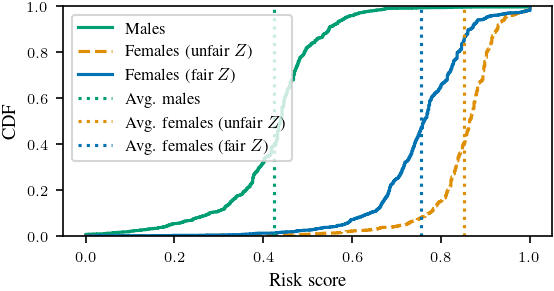

In [18]:
df_0 = data_df[data_df[f'{gender_col_name}_F'] == 0]
df_1 = data_df[data_df[f'{gender_col_name}_F'] == 1]

palette = sns.color_palette('colorblind')

f, axes = plt.subplots(1,1,figsize=(3.75,2), sharex=True, sharey=True)

sns.ecdfplot(x=df_1['risk_score_treat_male'], ax=axes, label='Males', color=palette[2])


sns.ecdfplot(x=df_0['risk_score_treat_female'], ax=axes, label='Females (unfair $Z$)', color=palette[1], linestyle='--')
sns.ecdfplot(x=df_0['risk_score_treat_male'], ax=axes, label='Females (fair $Z$)', color=palette[0])

axes.axvline(np.mean(df_1['risk_score_treat_male']), linestyle=':', color=palette[2], label='Avg. males')
axes.axvline(np.mean(df_0['risk_score_treat_female']), linestyle=':', color=palette[1], label='Avg. females (unfair $Z$)')
axes.axvline(np.mean(df_0['risk_score_treat_male']), linestyle=':', color=palette[0], label='Avg. females (fair $Z$)')
axes.set_ylabel('CDF')
axes.set_xlabel('Risk score')
axes.legend(ncols=1,fontsize=8)
plt.savefig('risk_cdf_imbalancedsynthetic.pdf', dpi=100)



---------
<h2 style="color:#007acc;">Balanced Synthetic Loan</h2>

---------

Generated with the following: $\beta=0.03, \gamma=0.5, \delta=1, \eta=5$


In [19]:
# choose: train, val, test, all
data_df = load_csv_file(root_path, 'balancedsynthetic', 'all')
params = load_yaml_config(root_path, 'balancedsynthetic')
oracle_meta_df = pd.read_csv('Data/treatment_balancedsynthetic/meta.csv', header=0) # contains the counterfactuals
oracle_data_df = pd.read_csv('Data/treatment_balancedsynthetic/data.csv', header=0) # original data

col_names = ['Gender_CF', 'Age_CF', 'Education_CF', 'Income_CF', 'Savings_CF', 'Loan_amt_CF', 'Duration_CF', 'Y_CF', 'Y_TTD',
       'Gender_PSDT', 'Age_PSDT', 'Education_PSDT', 'Income_PSDT', 'Savings_PSDT', 'Loan_amt_PSDT', 'Duration_PSDT',
       'Y_PDSL', 'Y_PSDT']
oracle_meta_df.columns = col_names

In [20]:
oracle = oracle_data_df.copy()
oracle_counterfactuals = oracle_meta_df.copy()
oracle.columns = [col + '_F' for col in oracle.columns]
merged_oracle = pd.concat([oracle, oracle_counterfactuals], axis=1)

In [21]:
treatment_col_idxs = range(params['dataset__num_sensitive'] + params['dataset__num_covariate'], 
                           params['dataset__num_sensitive'] + params['dataset__num_covariate'] + params['dataset__num_treatment'])

total_features = params['dataset__num_sensitive'] + params['dataset__num_covariate'] + params['dataset__num_treatment'] + 1

treatment_features = [c.split('_F')[0] for c in data_df.columns[treatment_col_idxs]]

print('Treatment features:', treatment_features)

gender_col_name = data_df.columns[0].split('_F')[0]
class_col_name = data_df.columns[total_features - 1].split('_F')[0]

Treatment features: ['Loan_amt', 'Duration']


### Downstream effect of Total treatment discrimination (TTD_E): $Y(S^F,X^F,do(Z=Z^{CF}))$

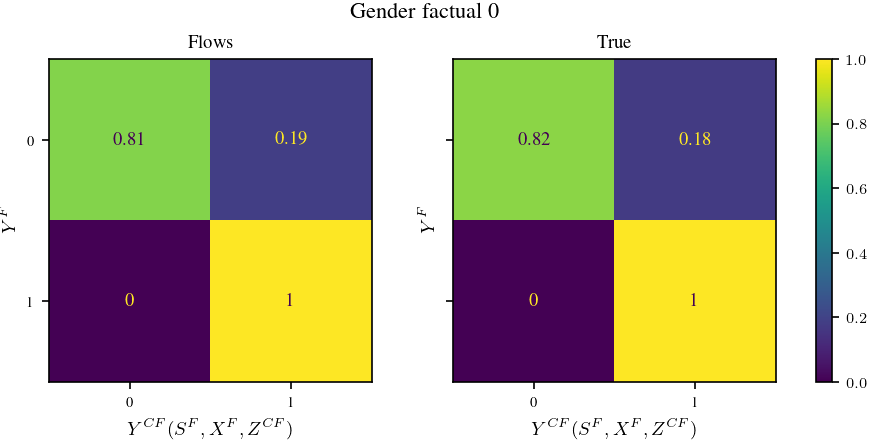

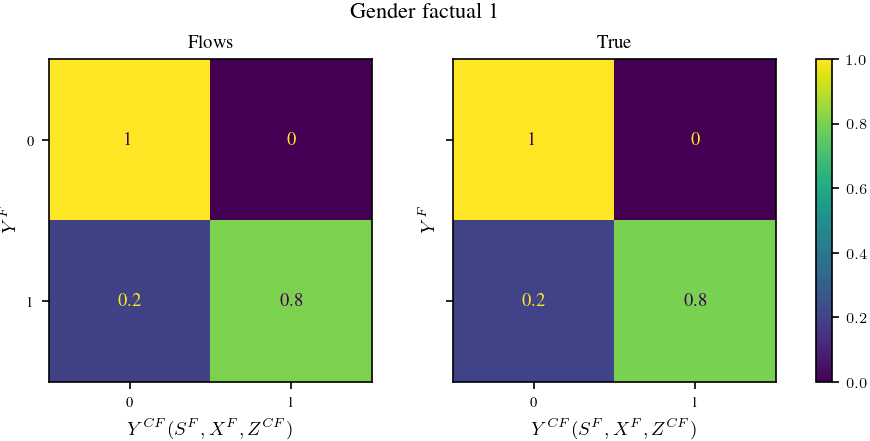

In [22]:
for gender_val in [0, 1]:
    f, axes = plt.subplots(1, 2, figsize=(6, 3), sharey='row')
    sens_0 = data_df[data_df[f'{gender_col_name}_F'] == gender_val]
    orac_m_0 = oracle_meta_df[oracle_data_df[f'{gender_col_name}'] == gender_val]
    orac_d_0 = oracle_data_df[oracle_data_df[f'{gender_col_name}'] == gender_val]
    cm_1 = confusion_matrix(sens_0[f'{class_col_name}_F'], sens_0[f'{class_col_name}_TTD'], labels=[0, 1], normalize='true')
    cm_2 = confusion_matrix(orac_d_0[f'{class_col_name}'], orac_m_0[f'{class_col_name}_TTD'], labels=[0, 1], normalize='true')
    disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=[0, 1])
    disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=[0, 1])
    disp_1.plot(ax=axes[0])
    disp_1.im_.colorbar.remove()
    disp_2.plot(ax=axes[1])
    disp_2.im_.colorbar.remove()
    axes[0].set_title('Flows')
    axes[1].set_title('True')
    for i in range(2):
        axes[i].set_ylabel('$Y^F$')
        axes[i].set_xlabel('$Y^{CF}(S^{F},X^{F},Z^{CF})$')
    f.suptitle(f'Gender factual {gender_val}')
    f.colorbar(disp_2.im_, ax=axes)

### Downstream effect of path-specific treatment(DTD_E): $Y(S^F,X^F,Z^CF(do(S=S^{CF}), do(X=X^F)))$

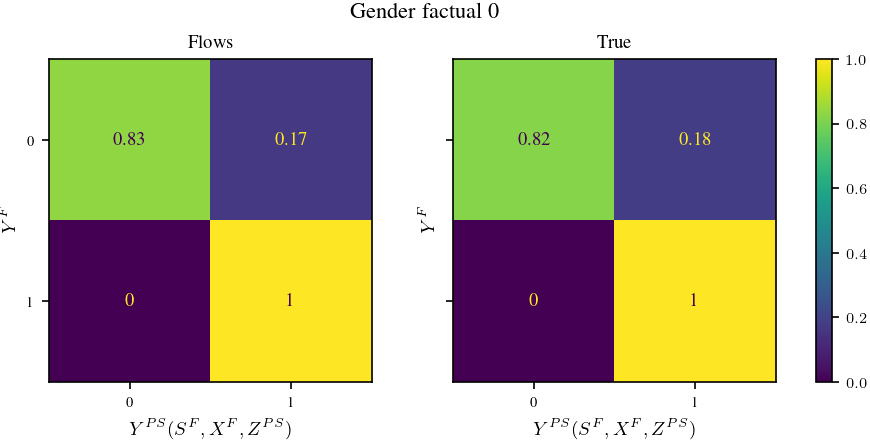

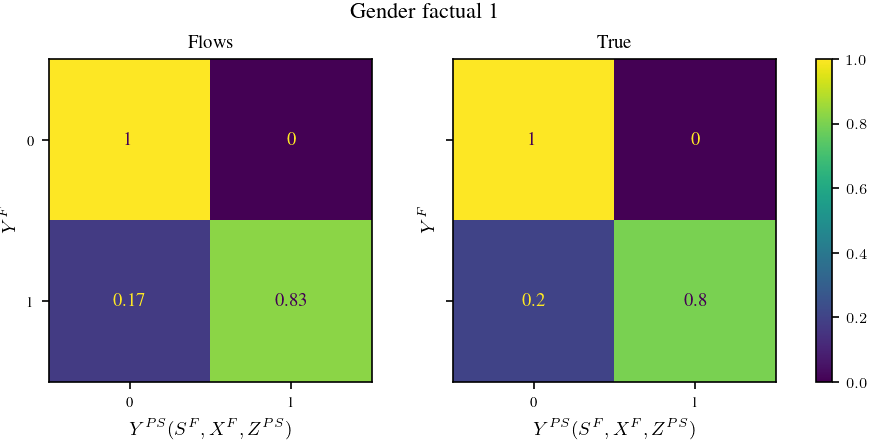

In [23]:
for gender_val in [0, 1]:
    f, axes = plt.subplots(1, 2, figsize=(6, 3), sharey='row')
    sens_0 = data_df[data_df[f'{gender_col_name}_F'] == gender_val]
    orac_m_0 = oracle_meta_df[oracle_data_df[f'{gender_col_name}'] == gender_val]
    orac_d_0 = oracle_data_df[oracle_data_df[f'{gender_col_name}'] == gender_val]
    cm_1 = confusion_matrix(sens_0[f'{class_col_name}_F'], sens_0[f'{class_col_name}_PSDT'], labels=[0, 1], normalize='true')
    cm_2 = confusion_matrix(orac_d_0[f'{class_col_name}'], orac_m_0[f'{class_col_name}_PSDT'], labels=[0, 1], normalize='true')
    disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=[0, 1])
    disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=[0, 1])
    disp_1.plot(ax=axes[0])
    disp_1.im_.colorbar.remove()
    disp_2.plot(ax=axes[1])
    disp_2.im_.colorbar.remove()
    axes[0].set_title('Flows')
    axes[1].set_title('True')
    for i in range(2):
        axes[i].set_ylabel('$Y^F$')
        axes[i].set_xlabel('$Y^{PS}(S^{F},X^{F},Z^{PS})$')
    f.suptitle(f'Gender factual {gender_val}')
    f.colorbar(disp_2.im_, ax=axes)

### Direct and Total Discrimination

For each group $S^F=0$ and $S^F=1$, Total Treatment Discrimination is:

$TTD_{S^F \in [0,1]} = Z^{CF}(do(S=S^{CF})) - Z^F$

Similarly, the Direct Treatment Discrimination is measured with respect to the path-specific of the treatment as:

$DTD_{S^F \in [0, 1]} = Z^{SPCF}(do(S=S^{CF}), do(X=X^F)) - Z^F$

In [24]:
plot_params = {'rows': 1, 'cols': 2, 'figsize': (7, 1.7), 'plot_idx_legend': 1}
result_dict = dtd_itd_analysis(data_df, params, plot=False, plot_params=plot_params)

In [25]:
for k in result_dict.keys():
    res = result_dict[k]
    cols = [f'{k}'] + [c for c in treatment_features]
    rows = []
    for meas in ['TD', 'DTD']:
        val_row = {cols[0]: meas}
        i = 1
        for c in treatment_features:
            val_row[cols[i]] = f'{res[meas][c][0]}+/-{res[meas][c][1]}'
            i += 1
        rows.append(val_row)
    df = pd.DataFrame(rows)
    print(df)
    print('---------')

  Overall                                  Loan_amt  \
0      TD  -0.3827479999999994+/-2.2004050269170397   
1     DTD  -0.3604035000000003+/-1.9948659727962061   

                                  Duration  
0  -1.2624085000000012+/-4.732796766542154  
1   -1.251187999999999+/-4.319171838727538  
---------
  Gender 0                                  Loan_amt  \
0       TD   -1.9126667000000002+/-0.746636140567012   
1      DTD  -1.6195120000000003+/-0.6884242890460286   

                                   Duration  
0            -4.439305+/-1.3058439229616028  
1  -4.2511410000000005+/-1.1353200536323114  
---------
  Gender 1                                Loan_amt  \
0       TD  2.138449999999999+/-0.8762841404022359   
1      DTD          1.8972676+/-0.9208926666049405   

                                 Duration  
0  4.637033000000001+/-1.3540656570959957  
1           4.055025+/-1.2777125308847714  
---------


### Analysis for Oracle Discrimination in Treatment

In [26]:
# merged_oracle
plot_params = {'rows': 1, 'cols': 2, 'figsize': (7, 1.7), 'plot_idx_legend': 1}
result_dict_oracle = dtd_itd_analysis(merged_oracle, params, plot=False, plot_params=plot_params)

In [27]:
for k in result_dict_oracle.keys():
    res = result_dict_oracle[k]
    cols = [f'{k}'] + [c for c in treatment_features]
    rows = []
    for meas in ['TD', 'DTD']:
        val_row = {cols[0]: meas}
        i = 1
        for c in treatment_features:
            val_row[cols[i]] = f'{res[meas][c][0]}+/-{res[meas][c][1]}'
            i += 1
        rows.append(val_row)
    df = pd.DataFrame(rows)
    print(df)
    print('---------')

  Overall                                 Loan_amt  \
0      TD  -1.4200000000000008+/-1.960180127704535   
1     DTD                 -1.5+/-2.008094792662099   

                      Duration  
0  -4.355+/-4.9553806014973265  
1    -4.48+/-5.004613568708486  
---------
  Gender 0                                   Loan_amt  \
0       TD  -1.9499999999999993+/-0.18291942812949052   
1      DTD                 -2.0+/-0.16494234692465334   

                     Duration  
0  -4.94+/-0.2466714067996968  
1  -5.0+/-0.22854050645175714  
---------
  Gender 1                                 Loan_amt  \
0       TD  1.9500000000000002+/-0.1828173281599181   
1      DTD                2.0+/-0.16339964574054544   

                                  Duration  
0  4.952999999999999+/-0.23702424958754648  
1                5.0+/-0.21682360069852286  
---------


### Mitigation Approaches

In [28]:

df_0 = data_df[data_df[f'{gender_col_name}_F'] == 0]
df_1 = data_df[data_df[f'{gender_col_name}_F'] == 1]

Females in this dataset seems to be at the disadvantage since the TTD has a negative downstream effect on them than the males.

In [29]:
#lgd
factual_female_lgd = np.mean((1 - df_0[f'{class_col_name}_F']) * df_0['Loan_amt_F'])
factual_male_lgd = np.mean((1 - df_1[f'{class_col_name}_F']) * df_1['Loan_amt_F'])
counterfactual_male_lgd = np.mean((1 - df_1[f'{class_col_name}_TTD']) * df_1['Loan_amt_CF'])
counterfactual_female_lgd = np.mean((1 - df_0[f'{class_col_name}_TTD']) * df_0['Loan_amt_CF'])
print(f"<LGD> Factual female: {factual_female_lgd}, Treated Females: {counterfactual_female_lgd}, Factual male: {factual_male_lgd}, Treated male: {counterfactual_male_lgd}",
)

# ESI
factual_female_esi = np.mean((df_0[f'{class_col_name}_F']) * (df_0['Loan_amt_F'] * df_0['Duration_F'] / 100))
factual_male_esi = np.mean((df_1[f'{class_col_name}_F']) * (df_1['Loan_amt_F'] * df_1['Duration_F'] / 100))
counterfactual_male_esi = np.mean((df_1[f'{class_col_name}_TTD']) * (df_1['Loan_amt_CF'] * df_1['Duration_CF'] / 100))
counterfactual_female_esi = np.mean((df_0[f'{class_col_name}_TTD']) * (df_0['Loan_amt_CF'] * df_0['Duration_CF'] / 100))
print(f"<ESI> Factual female: {factual_female_esi}, Treated Female: {counterfactual_female_esi},  Factual male: {factual_male_esi}, Treated male: {counterfactual_male_esi}")


<LGD> Factual female: 4.136151031212959, Treated Females: 3.139370272308416, Factual male: 3.0885818914540297, Treated male: 4.089488940396112
<ESI> Factual female: 0.35919566690616356, Treated Female: 0.5537442442169307,  Factual male: 0.5805825584378291, Treated male: 0.38153659454471206


### Risks


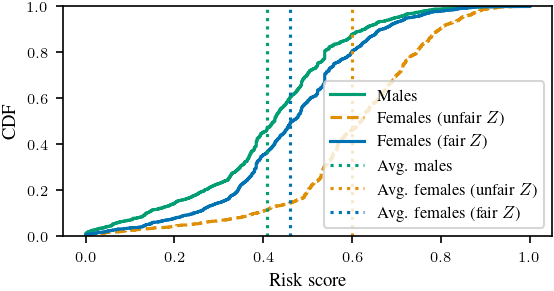

In [30]:
df_0 = data_df[data_df[f'{gender_col_name}_F'] == 0]
df_1 = data_df[data_df[f'{gender_col_name}_F'] == 1]

palette = sns.color_palette('colorblind')

f, axes = plt.subplots(1,1,figsize=(3.75,2), sharex=True, sharey=True)

sns.ecdfplot(x=df_1['risk_score_treat_male'], ax=axes, label='Males', color=palette[2])


sns.ecdfplot(x=df_0['risk_score_treat_female'], ax=axes, label='Females (unfair $Z$)', color=palette[1], linestyle='--')
sns.ecdfplot(x=df_0['risk_score_treat_male'], ax=axes, label='Females (fair $Z$)', color=palette[0])

axes.axvline(np.mean(df_1['risk_score_treat_male']), linestyle=':', color=palette[2], label='Avg. males')

axes.axvline(np.mean(df_0['risk_score_treat_female']), linestyle=':', color=palette[1], label='Avg. females (unfair $Z$)')
axes.axvline(np.mean(df_0['risk_score_treat_male']), linestyle=':', color=palette[0], label='Avg. females (fair $Z$)')
axes.set_ylabel('CDF')
axes.set_xlabel('Risk score')
axes.legend(ncols=1,fontsize=8)
plt.savefig('risk_cdf_balancedsynthetic.pdf', dpi=100)